In [3]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc, auc, classification_report, confusion_matrix


In [4]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [5]:
df = pd.read_csv('NSL-KDD\KDDTrain+_20Percent.txt', names=col_names, encoding='latin-1')

In [6]:
df.drop(['difficulty_level'],axis=1,inplace=True)

In [7]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

## Pre processing

### Hierarchy Generation

In [8]:
df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

### Standadization

In [9]:
#selection of numeric attribute columns from the dataset
numcol = df.select_dtypes(include = 'number').columns

from sklearn.preprocessing import StandardScaler

#normalizing using standard scalar
std_scalar = StandardScaler()
for i in numcol:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scalar.fit_transform(arr.reshape(len(arr),1))

### One Hot Encoding

In [10]:
categ_col = ['protocol_type','service','flag']
ctg = df[categ_col]

#one-hot encoding of categorical attributes
ctg = pd.get_dummies(ctg, columns = categ_col)

### Binary Classification

This is used for all of the 4 Artificial Neural Network Algorithms since we aim to do Binary Classification of the label either as attack or normal connection.

In [11]:
#categorize attack labels into 'normal' and 'attack'
biny_lbl = pd.DataFrame(df.label.map(lambda x:'normal' if x=='normal' else 'attack'))

In [12]:
#create dataframe with binary label
bin_dataset = df.copy()
bin_dataset['label'] = biny_lbl

In [13]:
#perform label encoding with binary labels
from sklearn import preprocessing

label_one = preprocessing.LabelEncoder()
encode_label = biny_lbl.apply(label_one.fit_transform)
bin_dataset['intrusion'] = encode_label

In [14]:
#one-hot encoding of the attack label
bin_dataset = pd.get_dummies(bin_dataset, columns = ['label'], prefix = "", prefix_sep = "")
bin_dataset['label'] = biny_lbl
bin_dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,attack,normal,label
0,-0.113551,tcp,ftp_data,SF,-0.009889,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,0.073120,-0.287993,-0.641804,-0.627365,-0.221668,-0.374281,1,0,1,normal
1,-0.113551,udp,other,SF,-0.010032,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,2.375620,-0.287993,-0.641804,-0.627365,-0.385140,-0.374281,1,0,1,normal
2,-0.113551,tcp,private,S0,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,1.603834,1.614454,-0.385140,-0.374281,0,1,0,attack
3,-0.113551,tcp,http,SF,-0.009996,0.052473,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.380894,0.073759,-0.574435,-0.604947,-0.385140,-0.342768,1,0,1,normal
4,-0.113551,tcp,http,SF,-0.010010,-0.034582,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,-0.641804,-0.627365,-0.385140,-0.374281,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,-0.113551,tcp,exec,RSTO,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,-0.641804,-0.627365,2.884296,2.777041,0,1,0,attack
25188,-0.113551,tcp,ftp_data,SF,-0.009954,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,2.764775,1.339894,-0.641804,-0.627365,-0.385140,-0.374281,0,1,0,attack
25189,-0.113551,tcp,private,REJ,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,-0.641804,-0.627365,2.884296,2.777041,0,1,0,attack
25190,-0.113551,tcp,nnsp,S0,-0.010093,-0.039310,-0.00891,-0.091223,-0.006301,-0.091933,...,-0.478183,-0.287993,1.603834,1.614454,-0.385140,-0.374281,0,1,0,attack


### Multi-class Classification

This can be used to classify the connection as what type of attact it is. We don't use this in next 4 deep learning algorithms

In [15]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = df.copy()
multi_label = pd.DataFrame(multi_data.label)


In [16]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
labencd = preprocessing.LabelEncoder()
enc_label = multi_label.apply(labencd.fit_transform)
multi_data['intrusion'] = enc_label


In [17]:
labencd.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [18]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label

### Feature Extraction

In [19]:
#creation of dataframe constrained to numeric attributes of encoded label attributes and binary class dataset 
numeric_bin = bin_dataset[numcol]
numeric_bin['intrusion'] = bin_dataset['intrusion']

C:\Users\dharaneish\AppData\Local\Temp\ipykernel_6584\1606513812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_bin['intrusion'] = bin_dataset['intrusion']


In [20]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)


count                       0.578790
srv_serror_rate             0.647817
serror_rate                 0.649952
dst_host_serror_rate        0.651050
dst_host_srv_serror_rate    0.653759
logged_in                   0.688084
dst_host_same_srv_rate      0.692212
dst_host_srv_count          0.719292
same_srv_rate               0.749237
intrusion                   1.000000
Name: intrusion, dtype: float64

In [21]:
# selecting attributes found by using pearson correlation coefficient
numeric_bin = bin_dataset[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate','logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]
     

In [22]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_bin = numeric_bin.join(ctg)
# then joining encoded, one-hot-encoded, and original attack label attribute
bin_dataset = numeric_bin.join(bin_dataset[['intrusion','attack','normal','label']])

In [23]:
bin_dataset

,count,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,attack,normal,label
0,-0.720244,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-0.779157,-0.813985,0.772109,0,...,0,0,0,0,1,0,1,0,1,normal
1,-0.624317,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-1.157831,-1.030895,-1.320567,0,...,0,0,0,0,1,0,1,0,1,normal
2,0.334947,1.600209,1.595477,1.603834,1.614454,-0.807626,-0.935081,-0.804947,-1.388806,0,...,1,0,0,0,0,0,0,1,0,attack
3,-0.694082,-0.187141,-0.193018,-0.574435,-0.604947,1.238197,1.069663,1.264742,0.772109,0,...,0,0,0,0,1,0,1,0,1,normal
4,-0.476067,-0.633978,-0.640142,-0.641804,-0.627365,1.238197,1.069663,1.264742,0.772109,0,...,0,0,0,0,1,0,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0.134374,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-1.091006,-0.976667,-1.343313,0,...,0,0,0,0,0,0,0,1,0,attack
25188,-0.728964,-0.633978,-0.640142,-0.641804,-0.627365,1.238197,1.069663,-0.687453,0.772109,0,...,0,0,0,0,1,0,0,1,0,attack
25189,0.177977,-0.633978,-0.640142,-0.641804,-0.627365,-0.807626,-1.046456,-0.922440,-1.343313,0,...,0,0,0,0,0,0,0,1,0,attack
25190,0.387271,1.600209,1.595477,1.603834,1.614454,-0.807626,-0.979631,-0.859174,-1.184088,0,...,1,0,0,0,0,0,0,1,0,attack


In [24]:

# creating a dataframe with only numeric attributes of multi-class dataset and encoded label attribute 
numeric_multi = multi_data[numcol]
numeric_multi['intrusion'] = multi_data['intrusion']

C:\Users\dharaneish\AppData\Local\Temp\ipykernel_6584\721849191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_multi['intrusion'] = multi_data['intrusion']


In [25]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.616431
logged_in                   0.692127
srv_serror_rate             0.710183
serror_rate                 0.711805
dst_host_serror_rate        0.713205
dst_host_srv_serror_rate    0.715996
dst_host_srv_count          0.716237
dst_host_same_srv_rate      0.716664
same_srv_rate               0.796708
intrusion                   1.000000
Name: intrusion, dtype: float64

In [26]:
# selecting attributes found by using pearson correlation coefficient
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]


In [27]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_multi = numeric_multi.join(ctg)
# then joining encoded, one-hot-encoded, and original attack label attribute
multi_data = numeric_multi.join(multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']])


In [28]:
multi_data

,count,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S3,flag_SF,flag_SH,intrusion,Dos,Probe,R2L,U2R,normal,label
0,-0.720244,-0.807626,-0.633978,-0.640142,-0.641804,-0.779157,-0.627365,-0.813985,0.772109,0,...,0,1,0,4,0,0,0,0,1,normal
1,-0.624317,-0.807626,-0.633978,-0.640142,-0.641804,-1.157831,-0.627365,-1.030895,-1.320567,0,...,0,1,0,4,0,0,0,0,1,normal
2,0.334947,-0.807626,1.600209,1.595477,1.603834,-0.935081,1.614454,-0.804947,-1.388806,0,...,0,0,0,0,1,0,0,0,0,Dos
3,-0.694082,1.238197,-0.187141,-0.193018,-0.574435,1.069663,-0.604947,1.264742,0.772109,0,...,0,1,0,4,0,0,0,0,1,normal
4,-0.476067,1.238197,-0.633978,-0.640142,-0.641804,1.069663,-0.627365,1.264742,0.772109,0,...,0,1,0,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0.134374,-0.807626,-0.633978,-0.640142,-0.641804,-1.091006,-0.627365,-0.976667,-1.343313,0,...,0,0,0,0,1,0,0,0,0,Dos
25188,-0.728964,1.238197,-0.633978,-0.640142,-0.641804,1.069663,-0.627365,-0.687453,0.772109,0,...,0,1,0,2,0,0,1,0,0,R2L
25189,0.177977,-0.807626,-0.633978,-0.640142,-0.641804,-1.046456,-0.627365,-0.922440,-1.343313,0,...,0,0,0,0,1,0,0,0,0,Dos
25190,0.387271,-0.807626,1.600209,1.595477,1.603834,-0.979631,1.614454,-0.859174,-1.184088,0,...,0,0,0,0,1,0,0,0,0,Dos


In [29]:
multi_data.columns

Index(['count', 'logged_in', 'srv_serror_rate', 'serror_rate',
       'dst_host_serror_rate', 'dst_host_same_srv_rate',
       'dst_host_srv_serror_rate', 'dst_host_srv_count', 'same_srv_rate',
       'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth',
       'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf',
       'service_daytime', 'service_discard', 'service_domain',
       'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i',
       'service_efs', 'service_exec', 'service_finger', 'service_ftp',
       'service_ftp_data', 'service_gopher', 'service_hostnames',
       'service_http', 'service_http_443', 'service_http_8001',
       'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell',
       'service_ldap', 'service_link', 'service_login', 'service_mtp',
       'service_name', 'service_netbios_dgm', 'service_netbios_ns',
       'service_netbios_ssn'

# Deep Learning

bin_dataset is sufficient for Deep Learning. first n-4 are x and intrusion is Y

In [30]:
df2 = bin_dataset.copy()
df2.to_csv("bin_data.csv")

In [31]:
##create input and output vectors
X = df2.iloc[:,0:df2.shape[1]-4]
Y = df2[['intrusion']]
print(X.shape)
X = X.values.reshape(df2.shape[0], df2.shape[1]-4, 1)
Y = Y.values.reshape(df2.shape[0], 1)

(25192, 89)


In [32]:
Z = Y
from keras.utils import to_categorical
Y = to_categorical(Y)
total_rows = 25192 * 4
max_len=4

In [33]:
## splitting of training and testing data
X_train,X_test,Z_train,Z_test = train_test_split(X,Z,test_size=0.20)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [34]:
print(X_train.shape, Y_train.shape)

(20153, 1, 89) (20153, 2)


In [35]:
sess1 = tf.compat.v1.Session()

## CNN

In [36]:
#CNN
model2 = Sequential()
model2.add(Conv1D(filters=256, kernel_size = 1, activation='tanh', dtype='float32', input_shape=(1,X.shape[1])))#256
model2.add(Conv1D(filters=128, kernel_size = 1, activation='tanh'))#128
model2.add(Conv1D(filters=64, kernel_size = 1, activation='tanh'))#64
model2.add(Conv1D(filters=32, kernel_size = 1, activation='tanh'))#32
model2.add(MaxPooling1D(pool_size=1))
model2.add(Flatten())
'''
model2.add(Conv1D(128, dropout=0.3, return_sequences=True)) #128
model2.add(Conv1D(64, dropout=0.3, return_sequences=True)) #64
model2.add(Conv1D(32))#32
'''
model2.add(Dense(100, activation='relu'))
model2.add((Dense(2, activation='softmax')))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted2= model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)


Epoch 1/50
79/79 [==============================] - 3s 10ms/step - loss: 0.1754 - accuracy: 0.9528 - val_loss: 0.0967 - val_accuracy: 0.9722
Epoch 2/50
79/79 [==============================] - 1s 7ms/step - loss: 0.0894 - accuracy: 0.9697 - val_loss: 0.0808 - val_accuracy: 0.9728
Epoch 3/50
79/79 [==============================] - 1s 7ms/step - loss: 0.0782 - accuracy: 0.9712 - val_loss: 0.0731 - val_accuracy: 0.9744
Epoch 4/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0736 - accuracy: 0.9723 - val_loss: 0.0729 - val_accuracy: 0.9742
Epoch 5/50
79/79 [==============================] - 1s 7ms/step - loss: 0.0706 - accuracy: 0.9746 - val_loss: 0.0693 - val_accuracy: 0.9796
Epoch 6/50
79/79 [==============================] - 1s 7ms/step - loss: 0.0689 - accuracy: 0.9767 - val_loss: 0.0663 - val_accuracy: 0.9798
Epoch 7/50
79/79 [==============================] - 1s 7ms/step - loss: 0.0670 - accuracy: 0.9769 - val_loss: 0.0661 - val_accuracy: 0.9811
Epoch 8/50
79/79 [=

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            23040     
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            32896     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             8256      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                        

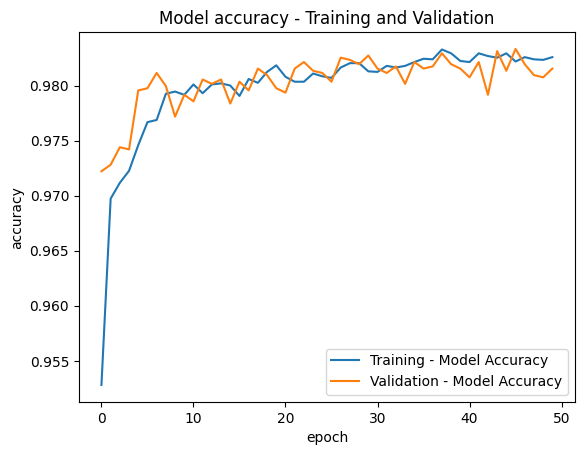

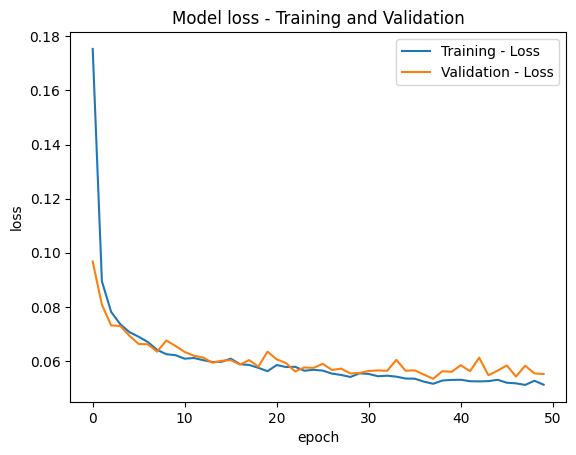

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2328
           1       0.98      0.99      0.98      2711

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039

Confusion Matrix
[[2271   57]
 [  36 2675]]
Accuracy Score        =     0.981543957134352
Precision Score       =     0.9791361639824304
Recall/Sensitivity    =     0.9867207672445591
Specificity           =     0.9755154639175257
F1 Score              =     0.9829138342825647


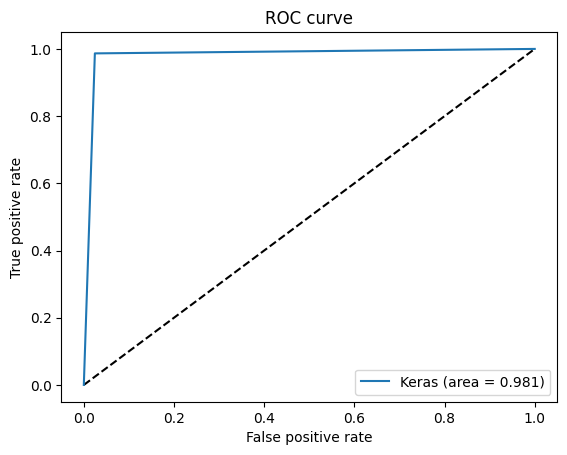

In [37]:
model2.summary()

y_pred = (model2.predict(X_test) > 0.5).astype("int32")
#y_pred = model2.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted2.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted2.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted2.history['loss'], label="Training - Loss")
plt.plot(predicted2.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## RNN

In [39]:

#create model (RNN)
model3 = Sequential()
model3.add(SimpleRNN(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True)) #128
model3.add(SimpleRNN(64, dropout=0.3, return_sequences=True)) #64
model3.add(SimpleRNN(32))#32

'''
#(For Single Layer)
model3.add(SimpleRNN(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model3.add(SimpleRNN(128))
'''

model3.add((Dense(2, activation='softmax')))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted3= model3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

Epoch 1/50
79/79 [==============================] - 6s 22ms/step - loss: 0.2192 - accuracy: 0.9208 - val_loss: 0.1203 - val_accuracy: 0.9635
Epoch 2/50
79/79 [==============================] - 1s 14ms/step - loss: 0.1568 - accuracy: 0.9479 - val_loss: 0.1028 - val_accuracy: 0.9680
Epoch 3/50
79/79 [==============================] - 1s 14ms/step - loss: 0.1466 - accuracy: 0.9501 - val_loss: 0.0982 - val_accuracy: 0.9712
Epoch 4/50
79/79 [==============================] - 1s 14ms/step - loss: 0.1415 - accuracy: 0.9515 - val_loss: 0.0934 - val_accuracy: 0.9716
Epoch 5/50
79/79 [==============================] - 1s 14ms/step - loss: 0.1395 - accuracy: 0.9519 - val_loss: 0.0912 - val_accuracy: 0.9726
Epoch 6/50
79/79 [==============================] - 1s 14ms/step - loss: 0.1320 - accuracy: 0.9538 - val_loss: 0.0837 - val_accuracy: 0.9736
Epoch 7/50
79/79 [==============================] - 1s 14ms/step - loss: 0.1297 - accuracy: 0.9555 - val_loss: 0.0839 - val_accuracy: 0.9722
Epoch 8/50
79

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 256)            88576     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 128)            49280     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 64)             12352     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 153,378
Trainable params: 153,378
Non-trainable params: 0
_________________________________________________________________
158/158 [==============================] - 1s 3m

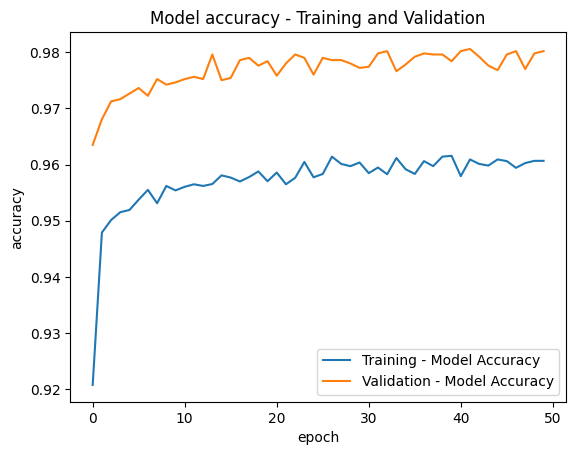

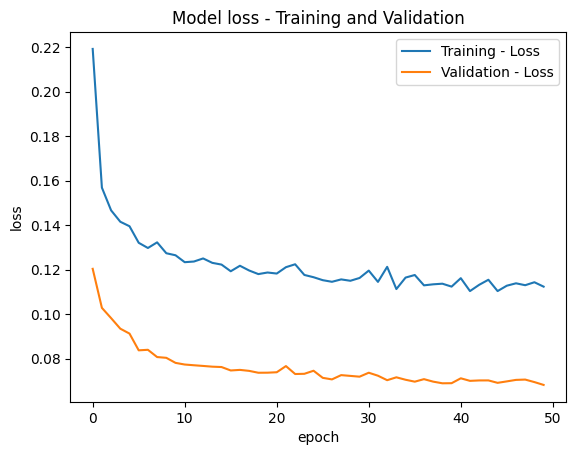

Classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2328
           1       0.97      0.99      0.98      2711

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039

Confusion Matrix
[[2258   70]
 [  30 2681]]
Accuracy Score        =     0.9801547926175829
Precision Score       =     0.9745547073791349
Recall/Sensitivity    =     0.9889339727037993
Specificity           =     0.9699312714776632
F1 Score              =     0.9816916880263639


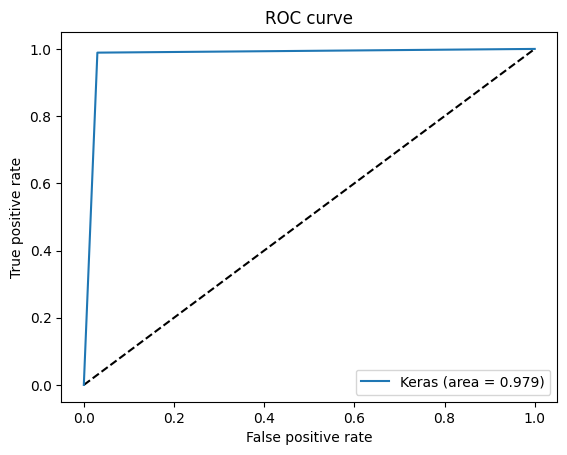

In [40]:
model3.summary()

y_pred = (model3.predict(X_test) > 0.5).astype("int32")
#y_pred = model3.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted3.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted3.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted3.history['loss'], label="Training - Loss")
plt.plot(predicted3.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


## LSTM

In [41]:
# create the model (LSTM)
# For stacked Layer
embedding_vecor_length = 1
model = Sequential()
model.add(LSTM(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1]))) #256
model.add(LSTM(128, dropout=0.3, return_sequences=True)) #128
model.add(LSTM(64, dropout=0.3, return_sequences=True)) #64
model.add(LSTM(32)) #32

'''
(For Single Layer)
model.add(LSTM(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model.add(LSTM(128))
'''

model.add((Dense(2, activation='softmax')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

Epoch 1/50
79/79 [==============================] - 14s 62ms/step - loss: 0.4190 - accuracy: 0.8512 - val_loss: 0.1414 - val_accuracy: 0.9651
Epoch 2/50
79/79 [==============================] - 3s 37ms/step - loss: 0.1589 - accuracy: 0.9459 - val_loss: 0.1127 - val_accuracy: 0.9692
Epoch 3/50
79/79 [==============================] - 3s 38ms/step - loss: 0.1400 - accuracy: 0.9524 - val_loss: 0.1000 - val_accuracy: 0.9708
Epoch 4/50
79/79 [==============================] - 3s 37ms/step - loss: 0.1360 - accuracy: 0.9537 - val_loss: 0.0947 - val_accuracy: 0.9718
Epoch 5/50
79/79 [==============================] - 3s 37ms/step - loss: 0.1295 - accuracy: 0.9556 - val_loss: 0.0901 - val_accuracy: 0.9730
Epoch 6/50
79/79 [==============================] - 3s 37ms/step - loss: 0.1241 - accuracy: 0.9574 - val_loss: 0.0849 - val_accuracy: 0.9734
Epoch 7/50
79/79 [==============================] - 3s 37ms/step - loss: 0.1263 - accuracy: 0.9551 - val_loss: 0.0838 - val_accuracy: 0.9734
Epoch 8/50
7

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            354304    
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 613,314
Trainable params: 613,314
Non-trainable params: 0
_________________________________________________________________
158/158 [==============================] - 3s 5m

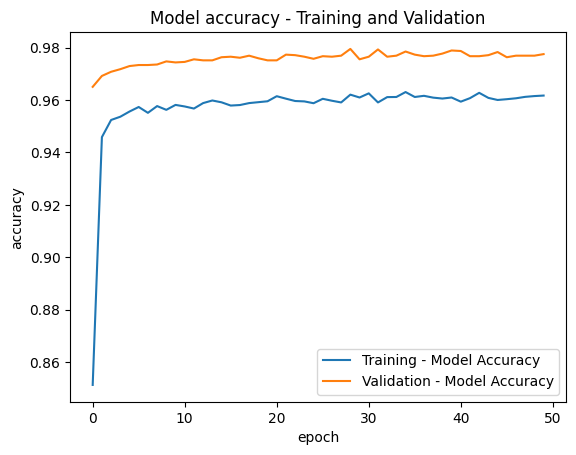

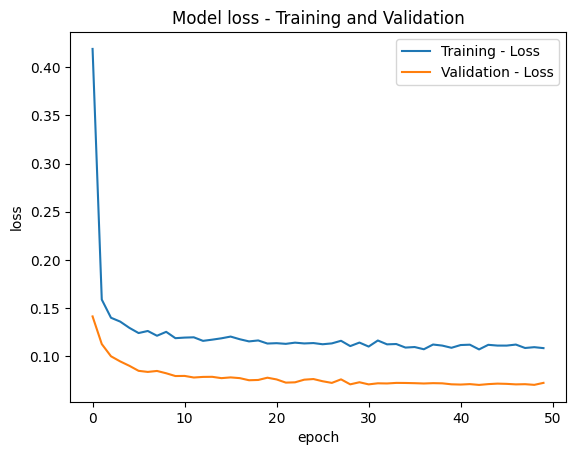

Classification report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2328
           1       0.97      0.99      0.98      2711

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039

Confusion Matrix
[[2238   90]
 [  23 2688]]
Accuracy Score        =     0.9775749156578686
Precision Score       =     0.9676025917926566
Recall/Sensitivity    =     0.9915160457395795
Specificity           =     0.961340206185567
F1 Score              =     0.9794133721989435


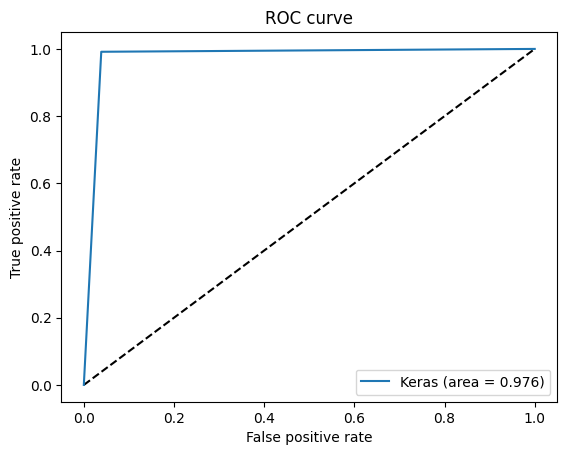

In [42]:
model.summary()

y_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted.history['loss'], label="Training - Loss")
plt.plot(predicted.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


## GRU

In [43]:
#create model (GRU)
# For stacked Layer
model1 = Sequential()
model1.add(GRU(256, dropout=0.3, return_sequences=True, input_shape=(1,X.shape[1])))#256
model1.add(GRU(128, dropout=0.3, return_sequences=True)) #128
model1.add(GRU(64, dropout=0.3, return_sequences=True)) #64
model1.add(GRU(32))#32

'''
(For Single Layer)
model1.add(GRU(128, dropout=0.3, return_sequences=True, input_shape=(1,4))) 
model1.add(GRU(128))
'''

model1.add((Dense(2, activation='softmax')))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

predicted1 = model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=256,callbacks=callbacks_list)

Epoch 1/50
79/79 [==============================] - 14s 55ms/step - loss: 0.3004 - accuracy: 0.9067 - val_loss: 0.1240 - val_accuracy: 0.9667
Epoch 2/50
79/79 [==============================] - 3s 32ms/step - loss: 0.1550 - accuracy: 0.9485 - val_loss: 0.1050 - val_accuracy: 0.9708
Epoch 3/50
79/79 [==============================] - 2s 29ms/step - loss: 0.1383 - accuracy: 0.9535 - val_loss: 0.0981 - val_accuracy: 0.9718
Epoch 4/50
79/79 [==============================] - 2s 28ms/step - loss: 0.1343 - accuracy: 0.9531 - val_loss: 0.0907 - val_accuracy: 0.9732
Epoch 5/50
79/79 [==============================] - 2s 28ms/step - loss: 0.1272 - accuracy: 0.9564 - val_loss: 0.0880 - val_accuracy: 0.9726
Epoch 6/50
79/79 [==============================] - 2s 28ms/step - loss: 0.1284 - accuracy: 0.9563 - val_loss: 0.0853 - val_accuracy: 0.9728
Epoch 7/50
79/79 [==============================] - 2s 28ms/step - loss: 0.1249 - accuracy: 0.9568 - val_loss: 0.0843 - val_accuracy: 0.9736
Epoch 8/50
7

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 256)            266496    
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            148224    
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             37248     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 461,442
Trainable params: 461,442
Non-trainable params: 0
_________________________________________________________________
158/158 [==============================] - 3s 4m

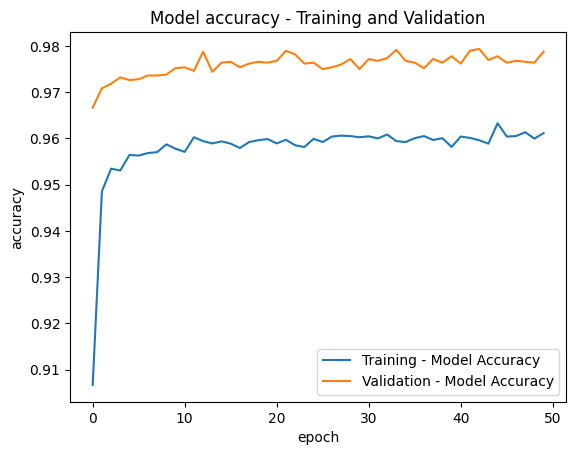

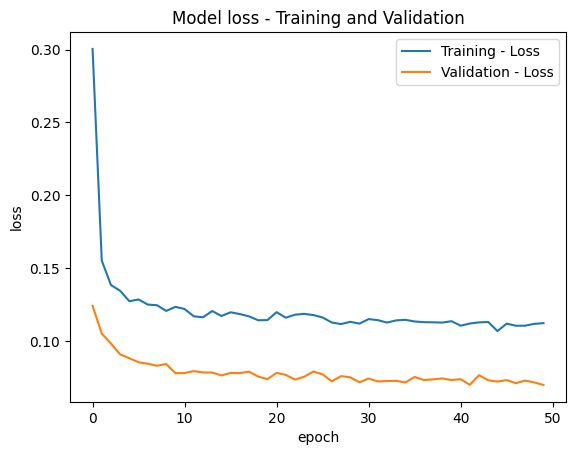

Classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2328
           1       0.97      0.99      0.98      2711

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039

Confusion Matrix
[[2252   76]
 [  31 2680]]
Accuracy Score        =     0.9787656281008137
Precision Score       =     0.9724238026124818
Recall/Sensitivity    =     0.9885651051272594
Specificity           =     0.9673539518900344
F1 Score              =     0.9804280226815438


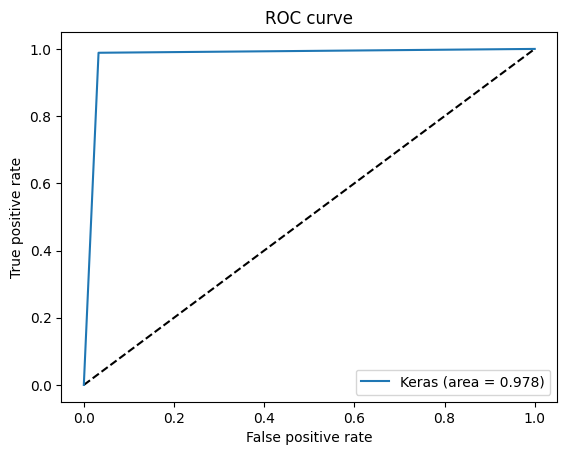

In [44]:
model1.summary()

y_pred = (model1.predict(X_test) > 0.5).astype("int32")
#y_pred = model1.predict(X_test)
print(y_pred.shape)
print(y_pred)

plt.plot(predicted1.history['accuracy'], label="Training - Model Accuracy")
plt.plot(predicted1.history['val_accuracy'], label="Validation - Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model accuracy - Training and Validation')
plt.legend(loc='lower right')
plt.show()

plt.plot(predicted1.history['loss'], label="Training - Loss")
plt.plot(predicted1.history['val_loss'], label="Validation - Loss")
plt.title('Model loss - Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

target_names = ['attack', 'normal']
print("Classification report")
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

print("Confusion Matrix")
print(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1) ))

#metrics
print("Accuracy Score        =    ", accuracy_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Precision Score       =    ", precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Recall/Sensitivity    =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("Specificity           =    ", recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=0))
print("F1 Score              =    ", f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1)))

fpr, tpr, threshold = roc_curve(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
auc_v = auc(fpr, tpr)

#plot ROC for better insight on classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_v))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
